In [ ]:
Pkg.add("Jacobi")
Pkg.add("FastGaussQuadrature")

In [ ]:
using Jacobi
using FastGaussQuadrature

f_0 = 1
H = 1

function b_n(n::Int64)
    numerator = -n*(n+1)
    denominator = (n+2)*(n+3)
    return numerator/denominator
end

function M_ij(size::Int64)
    fullMatrix = zeros(size,size)
    for i=0:size-1
        for j=0:size-1
            if i==j
                fullMatrix[i+1, j+1] = 2/(2*i+1) + (b_n(i)*b_n(i))*(2/(2*i+5))
            elseif i==j+2
                fullMatrix[i+1, j+1] = b_n(j)*(2/(2*j+5))
            elseif i==j-2
                fullMatrix[i+1, j+1] = b_n(i)*(2/(2*j+5))
            end
        end
    end
    return fullMatrix
end

function B_ij(size::Int64)
    fullMatrix = zeros(size,size)
    for i=0:size-1
        for j=0:size-1
            if i==j
                fullMatrix[i+1,j+1]=2/(2*i+1)
            elseif i==j-2
                fullMatrix[i+1,j+1]=b_n(i)*2/(2*i+5)
            end
        end
    end
    return fullMatrix
end

function L_ij(N::Function, size::Int64)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(10000)
    for i=0:size-1
        for j=0:size-1
            sumTotal = 0
            for k=0:size-1
                dp_i = 2.*(djacobi(values[k+1],i,0,0)+b_n(i)*djacobi(values[k+1],i+2,0,0))
                dp_j = 2.*(djacobi(values[k+1],j,0,0)+b_n(j)*djacobi(values[k+1],j+2,0,0))
                newPiece = weights[k+1]*(f_0*f_0/(H*H*N((values[k+1]+1.)/2.)*N((values[k+1]+1.)/2.)))*dp_i*dp_j
                sumTotal = sumTotal + newPiece
            end
            fullArray[i+1,j+1] = .5*sumTotal
        end
    end
    return fullArray
end

In [43]:
function u_g_rhs(u_bar::Function, size::Int64)
    fullArray = zeros(size)
    values, weights = gausslegendre(10000)
    for i =0:size-1
        sumTotal = 0
        for k=0:size-1
            p_n = jacobi(values[k+1], i,0,0) + b_n(i)*jacobi(values[k+1],i+2,0,0)
            sumTotal = sumTotal + weights[k+1]*p_n*u_bar((values[k+1]+1.)/2.)
        end
        fullArray[i+1] = .5*sumTotal
    end
    return fullArray
end

function u_galerkin_coefficients(u_bar::Function, size::Int64, MMatrix)
    u_lhs = MMatrix
    u_rhs = u_g_rhs(u_bar, size)
    return u_lhs \ u_rhs
end

function u_galerkin(coefficients, size::Int64, value::Float64)
    sumTotal = 0
    for i=0:size-1
        sumTotal = sumTotal + coefficients[i+1]*(jacobi(2.*value -1., i, 0,0)+b_n(i)*jacobi(2.*value -1.,i+2,0,0))
    end
    return sumTotal
end

function p_function(size::Int64, value::Float64)
    fullArray = zeros(size)
    for i=0:size-1
        fullArray[i+1] = jacobi(2.*value-1.,i,0,0)+b_n(i)*jacobi(2.*value-1.,i+2,0,0)
    end
    return fullArray
end

function dy_vartheta_bar(N::Function, du_bar::Function, value::Float64)
    return -(f_0*f_0/(H*H*N(value)*N(value)))*du_bar(value)
end

function dy_psi(u_bar::Function, size::Int64)
    return -u_galerkin(u_bar, size)
end

function dq_galerkin_coefficients(coefficients, du_bar::Function, N::Function, size::Int64, BMatrix)
    r_piece1 = L_ij(N, size)*coefficients
    r_piece2 = dy_vartheta_bar(N,du_bar,1.0)*p_function(size,1.0)
    r_piece3 = dy_vartheta_bar(N,du_bar,0.0)*p_function(size,0.0)
    lhs = BMatrix
    rhs = -r_piece1+r_piece2-r_piece3
    return lhs \ rhs
end

function dq_galerkin(coefficients, size::Int64, value::Float64)
    sumTotal = 0
    for i=0:size-1
        sumTotal = sumTotal + coefficients[i+1]*jacobi(2.*value-1.,i,0,0)
    end
    return sumTotal
end

dq_galerkin (generic function with 1 method)

In [7]:
function U_ij(size::Int64, u_galerkin_coefficients)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(10000)
    for i=0:size-1
        for j=0:size-1
            sumTotal = 0
            for k=0:size-1
                p_psi = jacobi(values[k+1],i,0,0)+b_n(i)*jacobi(values[k+1],i+2,0,0)
                p_q = jacobi(values[k+1],j,0,0)
                u_galerk = u_galerkin(u_galerkin_coefficients, size, (values[k+1]+1.)/2.)
                sumTotal = sumTotal + weights[k+1]*p_psi*p_q*u_galerk
            end
            fullArray[i+1, j+1] = .5*sumTotal
        end
    end
    return fullArray
end

function Q_ij(size::Int64, dq_galerkin_coefficients)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(10000)
    for i=0:size-1
        for j=0:size-1
            sumTotal = 0
            for k=0:size-1
                dq_galerk = dq_galerkin(dq_galerkin_coefficients, size, (values[k+1]+1.)/2.)
                p_psi_i = jacobi(values[k+1],i,0,0)+b_n(i)*jacobi(values[k+1],i+2,0,0)
                p_psi_j = jacobi(values[k+1],j,0,0)+b_n(j)*jacobi(values[k+1],j+2,0,0)
                sumTotal = sumTotal + weights[k+1]*dq_galerk*p_psi_i*p_psi_j
            end
            fullArray[i+1, j+1] = .5*sumTotal
        end
    end
    return fullArray
end

Q_ij (generic function with 1 method)

In [8]:
using Jacobi

function N_constant(value::Float64)
    return 1.
end

function z_linear(value::Float64)
    return value
end

function dz(value::Float64)
    return 1
end 

#B = B_ij(5)
#L = L_ij(N_constant, 5)
#M = M_ij(5)

#dpsi = dy_psi(z_linear, 5)
#p_function(5,1.0)
#dy_vartheta_bar(N_constant, dz,1.0)*p_function(5,1.0)

#ugc = u_galerkin_coefficients(z_linear,5,M)
#u_galerkin(ugc, 5, .5)
#U_ij(5, ugc)

#dqc = dq_galerkin_coefficients(z_linear, dz, N_constant, 5, B)
#dq_galerkin(dqc, 5, .3)
#Q_ij(5, dqc)

dz (generic function with 1 method)

In [55]:
sizeOfMatrix = 32
beta_value = 0
kx = 1
ky = 0

B = B_ij(sizeOfMatrix)
L = L_ij(N_constant, sizeOfMatrix)
M = M_ij(sizeOfMatrix)
u_coefficients = u_galerkin_coefficients(z_linear,sizeOfMatrix,M)
U = U_ij(sizeOfMatrix, u_coefficients)
dq_coefficients = dq_galerkin_coefficients(u_coefficients, dz, N_constant, sizeOfMatrix, B)
Q = Q_ij(sizeOfMatrix, dq_coefficients)

lhs = (U-(Q+beta_value*M)*inv((kx*kx+ky*ky)*M+L)*B)
(eig_values, eig_vectors) = eig(lhs, B)
eig_values

32-element Array{Float64,1}:
 -0.666716   
  3.75732e-19
 -7.67394e-11
 -5.35075e-17
  3.25232e-18
 -3.52825e-18
 -2.93991e-18
  1.7964e-17 
 -4.99281e-19
 -6.25279e-18
  1.26328e-17
  9.09027e-18
 -3.9935e-18 
  ⋮          
 -2.4933e-18 
 -3.498e-18  
 -6.11145e-18
 -4.47332e-18
  2.47916e-18
 -1.23917e-18
  7.94504e-19
 -2.20081e-18
 -2.49453e-18
 -7.66874e-18
 -3.81091e-20
  6.43883e-18

In [56]:
u_galerkin(u_coefficients,32,0.5)

-2.9059361643957716e-10

In [57]:
u_g_vals = zeros(101)
for i=1:101
    u_g_vals[i] = u_galerkin(u_coefficients,32,.01*(i-1))
end

In [49]:
u_g_vals

101-element Array{Float64,1}:
  1.32903e-6 
 -3.03227e-8 
  4.0863e-8  
  3.72437e-8 
 -2.90163e-8 
  3.42617e-8 
 -1.71146e-8 
  9.69348e-9 
  1.2366e-8  
 -1.92929e-8 
  2.02376e-8 
  8.49139e-10
 -1.4725e-8  
  ⋮          
  7.05071e-9 
 -3.5168e-9  
 -2.54238e-9 
  6.81805e-9 
 -7.22415e-9 
  5.82555e-9 
 -4.21416e-9 
  4.59086e-9 
 -7.24763e-9 
  8.83941e-9 
  9.24482e-9 
 -1.43363e-8 

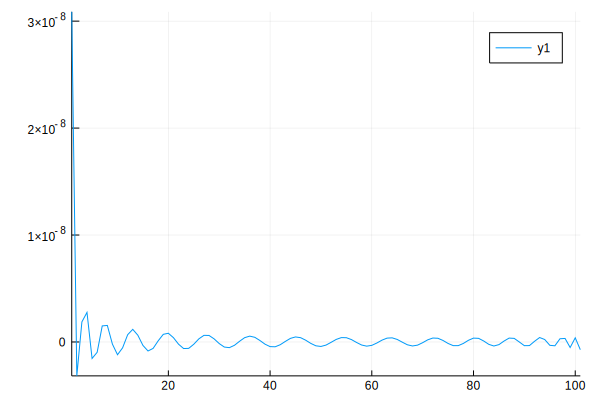

In [58]:
using Plots
plot(u_g_vals)